# **Titanic: Análisis de una tragedia**

*Nicole Lastra Quiroz - Julio 2022*



## I. Objetivo

* Predecir si un pasajero sobrevivió al hundimiento del Titanic o no, usando los algoritmos de aprendizaje supervisado: Random Forests y AdaBoost.

* Para cada uno en el conjunto de prueba, se debe predecir un valor de 0 o 1 para la variable `survived`.

## II. Breve Contexto

El hundimiento del Titanic es uno de los naufragios más conocidos de la historia.

<img src="https://miro.medium.com/max/1400/1*TD1TlRu96o_gDrM-NiBwpQ.jpeg" style="float:center ; padding:16px"/>

El 15 de abril de 1912, durante su viaje inaugural, el RMS Titanic, ampliamente considerado "insumergible", se hundió después de chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos a bordo, lo que resultó en la muerte de 1502 de los 2.224 pasajeros y la tripulación.

Si bien hubo algún elemento de suerte involucrado en sobrevivir, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

* En este taller, usted deberá crear un modelo predictivo que responda a la pregunta: "¿Qué tipo de personas tenían más probabilidades de sobrevivir?" utilizando datos de pasajeros (es decir, nombre, edad, sexo, clase socioeconómica, etc.). Muy importante, deberá usar exclusivamente los algoritmos de aprendizaje supervisado (Random forests y AdaBoost)

### Descripción de los datos

Los datos se han dividido en dos grupos:
* conjunto de entrenamiento (train.csv)
* conjunto de prueba (test.csv)

El conjunto de entrenamientodebe usarse para crear sus modelos de aprendizaje automático.Para el conjunto de entrenamiento, proporcionamos el resultado (también conocido como la “ground truth") para cada pasajero.

Su modelo se basará en "características" como el género y la clase de los pasajeros. También puede utilizar la ingeniería de funciones para crear nuevas funciones.
El conjunto de prueba debe usarse para ver qué tan bien se desempeña su modelo con datos invisibles. Para el equipo de prueba, no proporcionamos la “ground truth” para cada pasajero. Es su trabajo predecir estos resultados. Para cada pasajero en el conjunto de prueba, use el modelo que entrenó para predecir si sobrevivieron o no al hundimiento del Titanic.

#### Diccionario de datos

* Survived -> Supervivencia:  0 = No, 1 = Sí
* Pclass -> Clase del boleto: 1 = 1° clase, 2 = 2° clase, 3 = 3° clase
* Sex -> Sexo: Male, Female
* Age -> Edad en años
* Sibsp -> Número de hermanos / cónyuges a bordo del Titanic
* Parch -> Número de padres / hijos a bordo del Titanic
* Ticket -> Numero de ticket
* Fare -> Tarifa de pasajero
* Cabin -> Número de cabina
* Embarked -> Puerto de embarque : C = Cherburgo, Q = Queenstown, S = Southampton

#### Notas

_pclass_: un proxy para el estatus socioeconómico (SES) 
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

_Age_ -> la edad es fraccionaria si es menor que 1. Si se estima la edad, estará en la forma de xx.5

_sibsp_ -> el conjunto de datos define las relaciones familiares de esta manera:
* Sibling = hermano, hermana, hermanastro, hermanastra
* Spouse = esposo, esposa (se ignoraron las amantes y los novios)

_parch_ -> El conjunto de datos define las relaciones familiares de esta manera:
* Parent = madre, padre
* Child = hija, hijo, hijastra, hijastro
* Algunos niños viajaban solo con una niñera, por lo tanto, parch = 0 para ellos


## III. Análisis

### Importación de librerías

In [1]:
# Para tratamiento de los datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm
import multiprocessing

# Para gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns


#Para preprocesado y modelado
# ------------------------------------------------------------------------------
from pandas.core.series import Series
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Para configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Importación de datos

Comenzamos por montar el la información referida a Drive de Google, de modo que no tenga problemas para leer y extraer la información.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Una vez realizado este procedimiento, procedemos a Importar los datos como tal, copiando el directorio en el que se encuentran, en este caso están dentro de la carpeta _"Colab Notebooks"_ (carpeta de guardado por defecto de proyectos de Colab).


- _**Nota:**_ En caso de estar corriendo este trabajo directamente desde el archivo _".ipynb"_ o desde una copia creada en un Colab propio, recordar incluir los archivos de los datos, en la misma carpeta del respectivo Drive, de modo que no ocurran problemas al momento de la lectura. Estos archivos _".csv"_ están incluidos en el mismo _".zip"_ del _".ipynb"_ (para cualquier consulta, dirigirse al mail _nicole.lastra.quiroz@gmail.com_).

In [3]:
# Importación de datos de entrenamiento y prueba, respectivamente
# ------------------------------------------------------------------------------
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

### Visualización de datos

Para efectos de orden, se separarán los procesos relacionados al set de datos de entrenamiento y de prueba.


#### Set de datos de entrenamiento

Comenzaremos con una visualización simple de los datos como tabla, para luego revisar la cantidad de datos válidos y así mismo los ausentes, los tipos de datos presentes por columnas, para finalmente pasar a un análisis estadístico simple, de las columnas numéricas (mínimos, máximos, cuartiles, media, moda, entre otros).

In [4]:
# Visualización de las 5 primeras filas del set de datos de entrenamiento
# ------------------------------------------------------------------------------
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Información general de los datos de entrenamiento
# ------------------------------------------------------------------------------
train_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Información estadística del set de datos de entrenamiento
# ------------------------------------------------------------------------------
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Hallazgos generales en la visualización de los datos de entrenamiento:

* El data set de entrenamiento tiene 891 filas y 12 columnas.
* La columna _"Age"_ presenta 177 datos NaN, equivalente a un 19,87%.
* La columna _"Cabin"_ tiene menos del 23% de datos válidos.
* La columna _"Embarked"_ presenta 2 valores NaN.
* Existen 5 columnas con datos de categoría "object".

#### Set de datos de prueba

Procedemos con las mismas visualizaciones para el set de prueba.

In [7]:
# Visualización de las 5 primeras filas del set de datos de prueba
# ------------------------------------------------------------------------------
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
# Información general del set de datos de prueba
# ------------------------------------------------------------------------------
test_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
# Información estadística del set de datos de prueba
# ------------------------------------------------------------------------------
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Hallazgos generales en la visualización de los datos de prueba:

* El data set de prueba tiene 418 filas y 11 columnas.
* La columna _"Age"_ presenta 86 datos NaN, equivalente a un 20,57%.
* La columna _"Fare"_ presenta un único valor NaN.
* La columna _"Cabin"_ tiene menos del 22% de datos válidos.
* Existen 5 columnas con datos de categoría "object".

#### Gráficas relevantes

Como en todo proceso de estudio, las visualizaciones gráficas pueden aportar mucha información básica, por lo que revisaremos algunas que pueden presentar información interesante, en etapas tempranas del estudio.

Se considerará únicamente el set de datos de entrenamiento para estas, ya que contiene la principal columna de interés "Survived", para comparativas y cruce de información.

##### Gráficos de barras

1) Supervivencia de pasajeros:

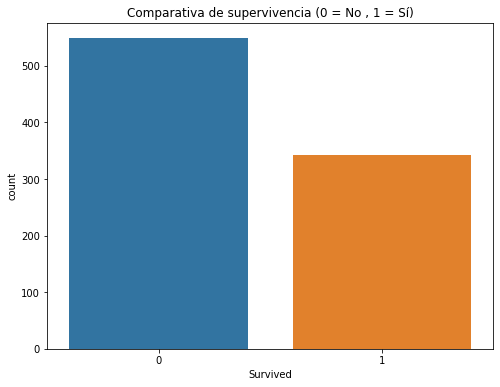

Número total de muertos : 549
Número total de sobrevivientes : 342


In [10]:
# Gráfico de barras dada la columna Survived en el set de entrenamiento
# ------------------------------------------------------------------------------
fig , ax = plt.subplots(figsize=(8,6))

sns.countplot(x    = "Survived", 
              data = train_data
              )

plt.title("Comparativa de supervivencia (0 = No , 1 = Sí)")
plt.show()

s0=len(train_data[train_data['Survived']==0])
s1=len(train_data[train_data['Survived']==1])

# Mostrar el numero total de muertos y sobrevivientes
# ------------------------------------------------------------------------------
print("Número total de muertos :" , s0)
print("Número total de sobrevivientes :", s1)

Hallazgos y deducciones: 
- En total, un 38.38% de personas abordo del Titanic sobrevive, mientras que un 61.61% de ellos muere. 

2) Supervivencia de pasajeros según sexo registrado:

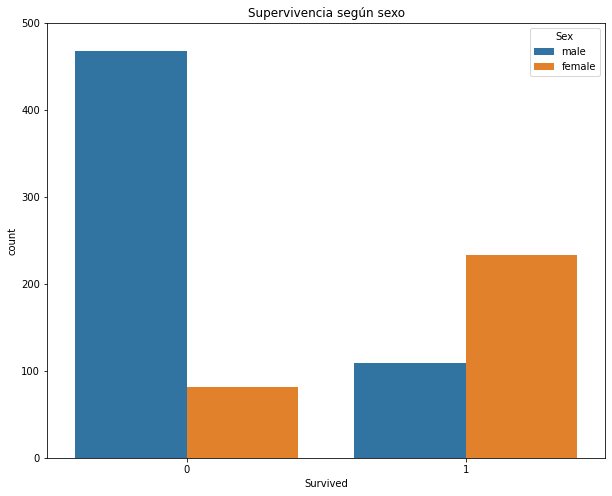

In [11]:
# Gráfico de barras segun "Sex" dado "Survived"
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,8))

sns.countplot(x    = "Survived", 
              data = train_data, 
              hue  = "Sex"
              )
ax.set_ylim(0,500)

plt.title("Supervivencia según sexo")
plt.show()

Hallazgos y deducciones: 
- Murieron más hombres que mujeres
- Las mujeres tenían una menor probabilidad de morir (esto da para un análisis filosofo-socioantropológico respecto al machismo de la época y el comportamiento de la sociedad, pero eso se escapa de los alcances de este trabajo)

3) Supervivencia de pasajeros según la clase del ticket adquirido:

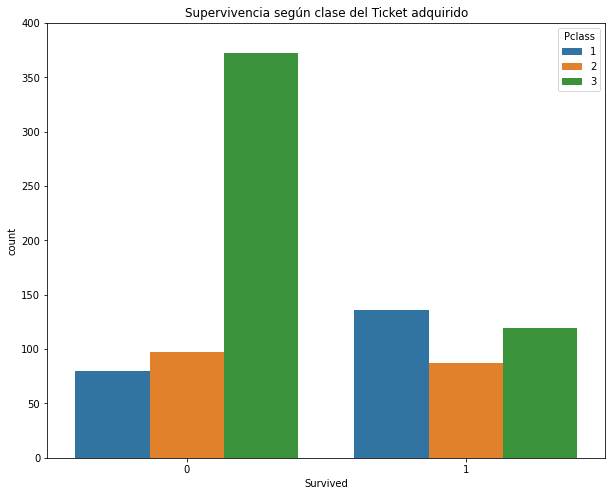

In [12]:
# Gráfico de barras de "Pclass" dada la columna "Suvived"
# ------------------------------------------------------------------------------
fig, ax=plt.subplots(figsize=(10,8))
sns.countplot(x    = "Survived", 
              data = train_data, 
              hue  = "Pclass")
ax.set_ylim(0,400)
plt.title("Supervivencia según clase del Ticket adquirido")
plt.show()


Hallazgos y deducciones: 
- Los de la 3° clase tenían mayor probabilidad de morir.
- La única clase en donde se ve una mayor probabilidad de vivir, versus a morir, es la 1°.
- La 2° clase tiene porcentajes de sobrevida versus muerte, más equilibrados que las otras categorías.

##### Correlaciones y Mapa de Calor

In [13]:
# División de variables numéricas
# ------------------------------------------------------------------------------
num = ["Age","SibSp","Parch","Fare"]

# Nuevo data frame con variables numéricas
# ------------------------------------------------------------------------------
corr_df = train_data[num]

# Correlación por método Pearson
# ------------------------------------------------------------------------------
cor     = corr_df.corr(method='pearson')
print(cor)

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


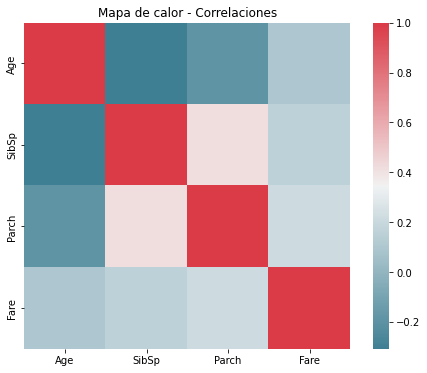

In [14]:
# Mapa de Calor para datos numéricos
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Mapa de calor - Correlaciones")

sns.heatmap(cor, 
            mask   = np.zeros_like(cor, dtype=np.bool), 
            cmap   = sns.diverging_palette(220, 10, as_cmap=True),
            square = True, 
            ax     = ax
            )
plt.show()

Hallazgos y deducciones: 
- A simple vista, no existe una fuerte correlación entre variables 
- La mayor correlación se aprecia entre las variables relativas a la columna "SibSp" y "Parch", y no es del todo extraño, ya que ambas tienen que ver con familiares.

### Limpieza de datos



#### Datos de entrenamiento

Considerando la información encontrada en el proceso anterior, se puede afirmar que la columna "Cabin" posee menos del 23% de datos válidos, lo que implica una ausencia de información cercana al 80%. En este caso procederemos a eliminar la columna, tal como sugiere hacer el profesor Balaraman Ravindran, actual directos del the Robert Bosch Centre for Data Science and Artificial Intelligence (RBC-DSAI), en los casos que se presentan ausencias de datos cercanas al 80%. Es preciso declarar que la columna "Cabin" podría habernos dado información relevante para el estudio, sin embargo al mostrar tal escacez de datos, su aporte se hace irrelevante.

Además, para efectos de estudio, las columnas relacionadas a "etiquetas" no aportan información relevante (como son las columnas "PassengerId", "Name" y "Ticket"), por lo que procederemos a eliminarlas.

In [15]:
# Eliminación de columnas
# ------------------------------------------------------------------------------
train_d = train_data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)

# Información general
# ------------------------------------------------------------------------------
train_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Ahora procederemos con el llenado de las columnas que tienen valores ausentes, como son "Age" y "Embarked".

En el caso de "Age", se opta por reemplazar los 177 datos por la media de la variable, es decir 29 años (aproximadamente la media es de 29,69 años, pero el set de datos sólo asignó valores enteros a las edades sobre el año, y pensando que nuestro modelo de medición de edad es a año cumplido, las personas con 29,69 años, aún tienen 29 años).

In [16]:
# Llenado de columna "Age"
# ------------------------------------------------------------------------------
media_train = 29
train_d["Age"] = train_d["Age"].fillna(media_train)
train_d.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


En el caso de "Embarked", sólo son 2 valores ausentes, que corresponden al tipo "object", por lo que se opta por reeemplazar con la moda.

In [17]:
# Moda de la columna "Embarked"
# ------------------------------------------------------------------------------
moda_train = train_d["Embarked"].mode()
print(moda_train)

0    S
dtype: object


In [18]:
# Llenado de la columna "Embarked" 
# ------------------------------------------------------------------------------
train_d["Embarked"] = train_d["Embarked"].fillna("S")
train_d.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Habiendo solucionado el llenado de las columnas con valores NaN, corresponde solucionar la problemática respecto a columnas con valores del tipo "object", por lo que realizaremos una recodificación de los datos presentes en ellas.

En el caso de la columna "Sex", los valores corrresponden a "female" y "male", los cuales, ahora serán respectivamente "0" y "1". Esto quiere decir que la descripción general quedaría como:

* Sex -> Sexo: Male = 1 , Female = 0

In [19]:
# Re-codificación de la columna "Sex"
# ------------------------------------------------------------------------------
train_d["Sex"].replace(["female", "male"],[0, 1], inplace = True)
train_d.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


En el caso de la columna "Embarked"

* Embarked -> Puerto de embarque : 0 = Cherburgo, 1 = Queenstown, 2 = Southampton

In [20]:
# Re-codificación de la columna "Embarked"
# ------------------------------------------------------------------------------
train_d["Embarked"].replace(["C", "Q", "S"],[0, 1, 2], inplace = True)
train_d.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


Ahora, el set de datos correspondiente al entrenamiento se encuentra en condiciones óptimas para ser trabajado. 

Se corrobora aplicando nuevamente la función `info()`, y verificando en su resumen la ausencia de valores NaN y la ausencia de variables tipo "object".

In [21]:
# Información general
# ------------------------------------------------------------------------------
train_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


#### Datos de prueba

En el caso de los datos de prueba, "Cabin" posee menos del 22% de datos válidos, por lo que también procederemos a eliminarla por los criterios ya mencionados para los datos de entrenamiento, en donde se repite la situación. 

En el caso de las columnas "PassengerId", "Name" y "Ticket", sucede lo mismo declarado anteriormente, no son relevantes para efectos de este estudio.

In [22]:
# Eliminación de columnas
# ------------------------------------------------------------------------------
test_d = test_data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# Información general
# ------------------------------------------------------------------------------
test_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


En este caso se debe proceder con el llenado de las columnas que tienen valores ausentes, como son "Age" y "Fare".

En el caso de "Age", nuevamente se opta por reemplazar los 86 datos por la media de la variable, en este caso 30 años (si bien es del orden de los 30,27 años, se justifica tal como en el caso anterior por el criterio usado en el data set y así mismo el criterio general de años cumplidos).

In [23]:
# Llenado de columna "Age"
# ------------------------------------------------------------------------------
media_test = 29
test_d["Age"] = test_d["Age"].fillna(media_test)
test_d.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


En el caso de "Fare", sólo es 1 valor ausente, que corresponden al tipo "float64", por lo que se opta por reeemplazar con la media.

In [24]:
# Moda de la columna "Fare"
# ------------------------------------------------------------------------------
media_test = test_d["Fare"].mean()
print(media_test)

# Llenado de la columna "Fare"
# ------------------------------------------------------------------------------
test_d["Fare"] = test_d["Fare"].fillna(media_test)
test_d.head()

35.627188489208635


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Tal como en el caso de los datos de prueba, procedemos con la transformación de las columnas "object" a "int", siguiendo el mismo procedimiento ya descrito.

In [25]:
# Re-codificación de las columnas "Sex" y "Embarked"
# ------------------------------------------------------------------------------
test_d["Sex"].replace(["female", "male"],[0, 1], inplace = True)
test_d["Embarked"].replace(["C", "Q", "S"],[0, 1, 2], inplace = True)
test_d.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


Ahora, el set de datos de prueba se encuentra en condiciones óptimas para ser trabajado. 

Se corrobora aplicando nuevamente la función `info()`, y verificando en su resumen la ausencia de valores NaN y la ausencia de variables tipo "object".

In [26]:
# Información general
# ------------------------------------------------------------------------------
test_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 23.0 KB


### Random Forest

Comenzamos con la definición de los grupos de datos de entrenamiento y prueba, que ya viene entregada por defecto, teniendo el cuidado de centrar el proceso en la variable de interés, en este caso "Survived", quien nos acusa la sobrevivencia de las personas abordo del Titanic.

In [27]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
train_df = train_d.drop(columns=["Survived"], axis=1)
y = train_d["Survived"]

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size = 0.3, random_state = 123)



#### Random Forest utilizando Grid Search basado en out-of-bag score

El proceso del random forest se realizará, con ayuda del Grid Search, bajo un `max_features` de 3, 5 y 7, es decir, se seleccionará un maximo de 3, 5 y 7 features del set de datos para generar los árboles, mientras que la profundidad máxima de ellos (`max_depth`), se establecerá como "None", 5 y 10. 

En el caso de los criterios, se compararán `gini` y `entropy` (pese a que por teoría y las condiciones del set, se podría presumir que el mejor resultado será según el criterio `entropy`).

El número de estimadores viene usualmente por defecto en 100, pero en esta ocasión se modificará a 150.

In [28]:
# Grid de hiperparámetros evaluados de acuerdo a condiciones preestablecidas
# ------------------------------------------------------------------------------
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [3, 5, 7],
                 'max_depth'   : [None, 5, 10],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ------------------------------------------------------------------------------
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
    )
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")


Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: 

In [29]:
# Visualización de Resultados
# ------------------------------------------------------------------------------

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head()

,oob_accuracy,criterion,max_depth,max_features,n_estimators
12,0.841091,entropy,5.0,3,150
13,0.834671,entropy,5.0,5,150
3,0.834671,gini,5.0,3,150
5,0.831461,gini,5.0,7,150
4,0.829856,gini,5.0,5,150


Bajo esta modalidad, el resultado con mejor precisión se da bajo el criterio `entropy` a una profundidad máxima de 10, considerando 7 features, alcanzando una precisión del 84.11%  (el mejor de los hiperparámetros encontrados `oob-accuracy` posee una precisión de 0.84109).

#### Versión Paralelizada

Repetiremos la acción, esta vez por un proceso paralelizado, estableciendo los mismos `max_features` y `max_depth` que en el caso anterior.

In [30]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ------------------------------------------------------------------------------

param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [3, 5, 7],
                 'max_depth'   : [None, 5, 10],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ------------------------------------------------------------------------------

def eval_oob_error(X, y, modelo, params, verbose = True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        bootstrap    = True,
        random_state = 123,
        ** params            
    )
    
    modelo.fit(X, y)
    
    if verbose:
        print(f"Modelo: {params} \u2713")
        
    return{'params': params, 'oob_accuracy': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes = n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train, y_train, RandomForestClassifier(), params) for params in param_grid]
             )


Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: 

In [31]:
# Visualización de Resultados
# ------------------------------------------------------------------------------
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis = 1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending = False)
resultados.head()

,oob_accuracy,criterion,max_depth,max_features,n_estimators
12,0.841091,entropy,5.0,3,150
13,0.834671,entropy,5.0,5,150
3,0.834671,gini,5.0,3,150
5,0.831461,gini,5.0,7,150
4,0.829856,gini,5.0,5,150


En la versión paralelizada, como era de esperar, el resultado es el mismo obtenido en el caso anterior. Es decir, el mejor resultado se obtiene bajo el criterio `entropy` a una profundidad máxima de 10, considerando 7 features, alcanzando una precisión del 84.11%  (el mejor de los hiperparámetros encontrados `oob-accuracy` posee una precisión de 0.84109).



#### Random Forest con Grid Search y validación cruzada


Esta vez realizaremos el Random Forest también utilizando Grid Search, con el agregado de validación cruzada. 

Para efectos comparativos, se establecen los mismos `max_features` y `max_depth` que en los casos anteriores.

In [32]:
# Grid de hiperparámetros evaluados
# ------------------------------------------------------------------------------
param_grid = {'n_estimators': [150],
              'max_features': [3, 5, 7],
              'max_depth'   : [None, 5, 10],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ------------------------------------------------------------------------------
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits     = 5 , 
                                   n_repeats    = 3, 
                                   random_state = 123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)



GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestClassifier(random_state=123), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10], 'max_features': [3, 5, 7],
                         'n_estimators': [150]},
             return_train_score=True, scoring='accuracy')

In [33]:
# Visualización de Resultados
# ------------------------------------------------------------------------------
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
13,entropy,5,5,150,0.825583,0.028762,0.867309,0.008807
4,gini,5,5,150,0.821295,0.027569,0.874397,0.009896
12,entropy,5,3,150,0.820735,0.024105,0.860618,0.006711
3,gini,5,3,150,0.820211,0.026764,0.866637,0.005999
14,entropy,5,7,150,0.819157,0.028870,0.871055,0.008093


Este método arroja un 82,55% en el `mean_test_score`, a una profundidad máxima de 10, considerando 3 features.

El hecho de que el set de entrenamiento arroje 86,73% en el `mean_train_score` habla de que no se ha producido un sobre entrenamiento del modelo, lo que es muy bueno.

Ya identificados los mejores hiperparámetros, se reentrena el modelo con los argumentos respectivos.

Observar que como establecimos que `refit = True` en el `GridSearchCV()`, el nuevo entrenamiento se realiza de forma automática y se guarda bajo `.best_estimator` .

In [34]:
modelo_final = grid.best_estimator_

#### Predicción y evaluación del modelo final

En este paso paso utilizaremos el set de datos de prueba, para evaluar la capacidad de predicción del modelo final.

In [35]:
# Error de test del modelo final
# ------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test)
predicciones[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [36]:
# Matriz de confusión
# ------------------------------------------------------------------------------
mat_confusion = confusion_matrix(
                    y_true = y_test,
                    y_pred = predicciones
                    )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[154  16]
 [ 30  68]]

El accuracy de test es: 82.83582089552239 %


In [37]:
# Reporte de clasificación
# ------------------------------------------------------------------------------
print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       170
           1       0.81      0.69      0.75        98

    accuracy                           0.83       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.83      0.83      0.83       268



Luego de la optimización de los hiperparametros se consiguió un accuracy del 82,84%.

#### Predicción de Probabilidades

Sólo para efector educativos, vamos a predecir y visualizar las probabilidades de ocurrencia, de a cuerdo al modelo final, de 7 casos posibles.

In [38]:
# Predicción de probabilidades
# ------------------------------------------------------------------------------
predicciones = modelo_final.predict_proba(X = X_test)
predicciones[:7, :]

array([[0.35280946, 0.64719054],
       [0.85409858, 0.14590142],
       [0.58655111, 0.41344889],
       [0.79157817, 0.20842183],
       [0.81136977, 0.18863023],
       [0.88776854, 0.11223146],
       [0.1312467 , 0.8687533 ]])

In [39]:
# Clasificación empleando la clase de mayor probabilidad
# ------------------------------------------------------------------------------
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['Predicción de sobrevida'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(7)

,0,1,Predicción de sobrevida
0,0.352809,0.647191,1
1,0.854099,0.145901,0
2,0.586551,0.413449,0
3,0.791578,0.208422,0
4,0.811370,0.188630,0
5,0.887769,0.112231,0
6,0.131247,0.868753,1


Esto se traduce en, por ejemplo para el primer caso, la visualización de probabilidades de morir o vivir (aproximados del 35,28% y 64,72% respectivamente). De acuerdo a los resultados, este primer caso lograría sobrevivir a la tragedia.

Lo mismo se repite para los siguientes 6 casos enlistados, en donde vemos que sólo el último caso logra sobrevivir y con una probabilidad mayor a la del primer caso estudiado.

Notar que estas probabilidades son por caso particular, no se repiten de forma constante para todos los casos a los que estudiemos su supervivencia, por esto es tan importante el revisar la predicción de probabilidades y saber con qué porcentaje d probabilidad se está tomando la decición final sobre si vive o muere.

#### Importancia de predictores



Realizaremos una breve revisión a la importancia de los predictores según pureza de nodos y por permutaciones realizadas.

##### Por pureza de nodos

In [40]:
# Visualización de importancia de predictores por pureza de nodos
# ------------------------------------------------------------------------------
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,Sex,0.415626
5,Fare,0.175574
2,Age,0.173785
0,Pclass,0.151985
3,SibSp,0.052254
6,Embarked,0.018212
4,Parch,0.012564


Esto guarda relación con algo que se había observado en etapas iniciales de este análisis. El predictor de supervivencia tiene una marcada tendencia según la variable `Sex`, ya que como recordaremos, las mujeres tenían una sobrevida mucho más alta y marcada que los hombres.

##### Por Permutación


In [41]:
# Visualización de importancia de predictores por permutaciones 
# ------------------------------------------------------------------------------
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
# ------------------------------------------------------------------------------
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
1,0.242357,0.016014,Sex
0,0.122737,0.010276,Pclass
2,0.089255,0.011168,Age
5,0.045229,0.010303,Fare
3,0.018836,0.003647,SibSp
6,0.006384,0.001889,Embarked
4,0.002139,0.001351,Parch


En este caso podemos además, visualizar la importancia de los predictores con el aumento de su error respectivo a medida que se realizan las permutaciones, tal como se muestra a continuación.

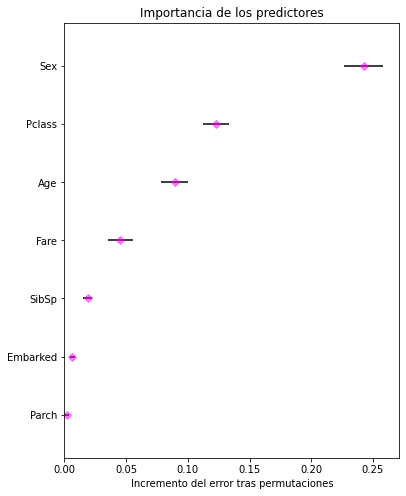

In [42]:
# Gráfica de importancia de predictores
# ------------------------------------------------------------------------------
fig, ax        = plt.subplots(figsize=(6, 8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)

ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr  = df_importancia['importances_std'],
    align = 'center',
    alpha = 0
)

ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker    = "D",
    linestyle = "",
    alpha     = 1.5,
    color     = "magenta"
)

ax.set_title('Importancia de los predictores')
ax.set_xlabel('Incremento del error tras permutaciones');

Podemos apreciar que la variable `Sex` presenta un mayor incremento del error tras permutaciones, seguida por `Fare` y `Age`.

Recordemos que `Pclass` es el segundo predictor en importancia, pero observamos en la gráfica que se mantiene con un menor aumento de error, por ejemplo, que la variable `Sex` (quien se encuentra en primer lugar de importancia de los predictores).


Con este último paso, damos por terminado el análisis de los datos por Random Forest.

### AdaBoost

En esta sección, realizaremos un análisis de los datos con AdaBoost, específicamente con ayuda de `GradientBoostingRegressor`.

Seguiremos casi la misma estructura que con Random Forest, por lo que comenzaremos con la división de los datos, luego con la creación y entrenamiento del modelo, para luego estudiar sus niveles de predicción, así como diferentes formas de trabajar con ayuda de `GridSearch` (notar que iniciallmente utilizaremos `n_estimators` = 150, para seguir con la misma dinámica utilizada en el caso de Random Forest). 

#### División de los datos

In [43]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
train_df = train_d.drop(columns = "Survived", axis = 1)
y = train_d["Survived"]

X_train, X_test, y_train, y_test = train_test_split(train_df, y, random_state = 123)

#### Creación y entrenamiento del modelo

In [44]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = GradientBoostingClassifier(
            n_estimators = 150,
            max_features = 'auto',
            random_state = 123
         )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

GradientBoostingClassifier(max_features='auto', n_estimators=150,
                           random_state=123)

Una información relevante para comparar modelos mas adelante, es que los valores por defecto de los siguientes hiperparámetros que no están definidos aquí, son:
- `max_depth` = 3
- `learning_rate` = 0.1

#### Predicción y evaluación del modelo creado

In [45]:
# Accuracy de test del modelo inicial
# ------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
            )

print(f"La precisión del test es: {accuracy}")

La precisión del test es: 0.8430493273542601


Este primer modelo entrega una precisión del 84.30%, pero utiliza varios hyperparámetros por defecto, por lo que ahora revisaremos cuales son los valores óptimos de algunos de esos hyperparámetros (`n_sestimators` y `learning_rate`).

#### Número de arboles

Como al inicio de un análisis no se sabe con exactitud cuales son los hiperparámetros más adecuados, es que se hace necesario revisar cuál es el valor optimo de cada uno de ellos, en este caso primero revisaremos el número óptimo de árboles.


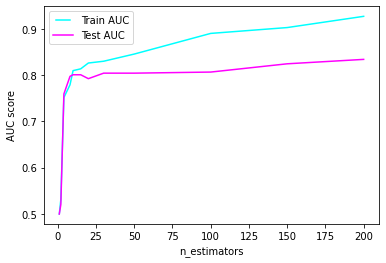

In [46]:
n_estimators = [1, 2, 4, 8, 10, 15, 20, 30, 50, 100, 150, 200]

train_results = []
test_results = []

for estimator in n_estimators:

   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   
   train_results.append(roc_auc)
   
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   
   test_results.append(roc_auc)
   

line1, = plt.plot(n_estimators, train_results, "cyan", label = "Train AUC")
line2, = plt.plot(n_estimators, test_results, "magenta", label = "Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

Desde la gráfica podríamos inferir que los candidatos a valores óptimos de de árboles podrían ser 20, 30 y considerando un a ligera estabilización en el set de prueba, pero una mejora de valores para el set de entrenamiento, 50.

No realizaremos mayores estudios ya que generaremos un modelo óptimo para los diversos hyperparámetros con ayuda de un grid search y validación cruzada, para luego comprar con los supuestos encontrados.





#### Learning rate

Este es uno de los hiperparámetros más importantes, junto con el número de árboles. 
A continuación revisaremos dos versiones para decidir cuál es el óptimo `learning_rate` para nuestro modelo.

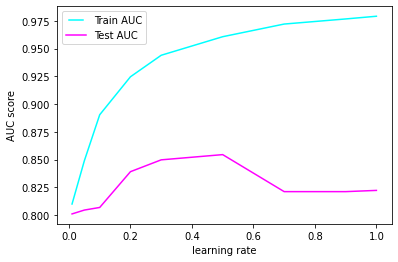

In [47]:
# Estudio Learning rate - forma A
# ------------------------------------------------------------------------------
learning_rates = [1, 0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
train_results  = []
test_results   = []

for eta in learning_rates:

   model = GradientBoostingClassifier(learning_rate = eta)
   model.fit(X_train, y_train)

   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)

   train_results.append(roc_auc)

   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   
   test_results.append(roc_auc)

# Gráfica de resultados
# ------------------------------------------------------------------------------

line1, = plt.plot(learning_rates, train_results, "cyan", label="Train AUC")
line2, = plt.plot(learning_rates, test_results, "magenta", label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints = 2)})
plt.ylabel("AUC score")
plt.xlabel("learning rate")
plt.show()

En este primer estudio, usamos los datos por defecto para evaluar sólo diferentes valores para `learning_rate` (recordar que el `max_depth` por defecto es 3 y el `n_estimators` es de 100). 

En la gráfica llaman la atención dos puntos, `leaning_rate` igual a 0.1, e igual a 0.5, según se desee trabajar con mayor o menor riesgo de over fitting se podría seleccionar uno o el otro, ya que en el caso del 0.5 vemos que que el AUC score del set de entrenamiento supera ligeramente el 0.95, mientras que al seleccionar el 0.1 sería tomar un camino más seguro. 

Para efectos de decisión, realizaremos otro estudio modificando el `n_estimators` por un valor de arboles más acotado, específicamente 20, que fue el `n_estimators` utilizado por modelo con grid search y validación cruzada en el random forest, así decidiremos si es mejor usar alguno de los dos valores que aquí llaman la atención, para usando un estimado de árboles más significativo para efectos de estudio.



In [48]:
# Estudio del Learning rate - forma B
# ------------------------------------------------------------------------------
lr_list = [1, 0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]

for learning_rate in lr_list:

    modelo = GradientBoostingClassifier(
                                      n_estimators  = 20, 
                                      learning_rate = learning_rate, 
                                      max_features  = "auto", 
                                      random_state  = 123
                                      )
    modelo.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(modelo.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(modelo.score(X_test, y_test)))

Learning rate:  1
Accuracy score (training): 0.931
Accuracy score (test): 0.848
Learning rate:  0.9
Accuracy score (training): 0.918
Accuracy score (test): 0.830
Learning rate:  0.7
Accuracy score (training): 0.922
Accuracy score (test): 0.843
Learning rate:  0.5
Accuracy score (training): 0.909
Accuracy score (test): 0.852
Learning rate:  0.3
Accuracy score (training): 0.883
Accuracy score (test): 0.834
Learning rate:  0.2
Accuracy score (training): 0.870
Accuracy score (test): 0.830
Learning rate:  0.1
Accuracy score (training): 0.850
Accuracy score (test): 0.821
Learning rate:  0.05
Accuracy score (training): 0.840
Accuracy score (test): 0.834
Learning rate:  0.01
Accuracy score (training): 0.614
Accuracy score (test): 0.623


Confirmamos los buenos valores conseguidos para un `learning_rate` de 0.1 y 0.5, pero dejaremos que el grid seach con validación cruzada nos ayude finalmente a decidir la mejor opción para un modelo óptimo.

#### AdaBoost con Grid Search y validación cruzada

Realizaremos la busqueda de hiperparámetros con ayuda de un grid search para encontrar un modelo óptimo.

In [49]:
# Grid de hiperparámetros evaluados
# ------------------------------------------------------------------------------
param_grid = {'n_estimators'  : [10, 20, 30, 50, 100],
              'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [1, 3, 5, 10],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.1, 0.5]
             }

# Búsqueda por grid search con validación cruzada
# ------------------------------------------------------------------------------
grid = GridSearchCV(
        estimator  = GradientBoostingClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(
                                  n_splits     = 5, 
                                  n_repeats    = 3, 
                                  random_state = 123
                                   ), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ------------------------------------------------------------------------------
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_learning_rate,param_max_depth,param_max_features,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
37,0.1,3,auto,50,1,0.830348,0.032259,0.881735,0.007361
59,0.1,3,log2,100,1,0.830345,0.033639,0.886480,0.008791
49,0.1,3,sqrt,100,1,0.830345,0.033639,0.886480,0.008791
35,0.1,3,auto,30,1,0.829862,0.030624,0.861776,0.009017
65,0.1,5,auto,30,1,0.829847,0.032481,0.913550,0.007719


Utilizando Grid Search y validación cruzada, obtenemos un número óptimo de `n_estimators = 50`, un `max_deapth = 3`, y un `learning_rate = 0.1`, estas apreciaciones coinciden con lo que habíamos revisado en modelos anteriores para llegar a buenos hyperparámetros (no nos encontramos con ningún valor sorpresa, o un modelo que escapara de lo que habíamos visto).

Recordemos que como `refit = True`, el modelo se gurada automáticamente bajo `grid.best_estimator_` por lo que podemos trabajar directamente con él para realizar las pruebas de accuracy y los demás estudios.


In [50]:
modelo_final = grid.best_estimator_

Predicción y evaluación del modelo

In [58]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test)
predicciones[:7]

array([1, 0, 0, 0, 0, 0, 1])

In [59]:
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[126  13]
 [ 25  59]]

El accuracy de test es: 82.95964125560538 %


Finalmente el accuracy del modelo es de un 82.96% aproximadamente.

#### Predicción de probabilidades

Nuevamente vamos a predecir y visualizar las probabilidades de ocurrencia, de a cuerdo al modelo final, de 7 casos posibles, tal como lo hicimos al estudiar el caso por random forest.

In [53]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelo_final.predict_proba(X = X_test)
predicciones[:7, :]

array([[0.31797842, 0.68202158],
       [0.87056178, 0.12943822],
       [0.54957702, 0.45042298],
       [0.79024321, 0.20975679],
       [0.85422477, 0.14577523],
       [0.91018366, 0.08981634],
       [0.0542072 , 0.9457928 ]])

In [54]:
# Clasificación empleando la clase de mayor probabilidad
# ==============================================================================
df_predicciones = pd.DataFrame(data = predicciones, columns=['0', '1'])
df_predicciones['Predicción de sobrevida'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(7)

,0,1,Predicción de sobrevida
0,0.317978,0.682022,1
1,0.870562,0.129438,0
2,0.549577,0.450423,0
3,0.790243,0.209757,0
4,0.854225,0.145775,0
5,0.910184,0.089816,0
6,0.054207,0.945793,1


Esto se traduce en, por ejemplo para el último caso, la visualización de probabilidades de morir o vivir (aproximados del 32,18% y 67,81% respectivamente). De acuerdo a los resultados, este primer caso lograría sobrevivir a la tragedia.

Lo mismo se repite para los 6 casos restantes, en donde vemos que ninguno de los casos logra sobrevivir, casi todos con probabilidades mayores al 73% de certeza, salvo el primer caso, en donde sólo llega al 55,9%.

Se debe recordar que estas probabilidades son por caso particular, no se repiten de forma sistemática para todos los resultados que se estudien, por esto es tan importante el revisar la predicción de probabilidades y saber con qué porcentaje de probabilidad se está tomando la decición final sobre si la persona sobrevive o no.

#### Importancia de predictores

Tal como en el caso del random forest, aquí revisaremos la importancia de predictores por pureza de nodos y por permutación, como se detalla a continuación:

##### Pureza de nodos

In [55]:
# Importancia por pureza de nodos
# ------------------------------------------------------------------------------
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending = False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,Sex,0.501519
0,Pclass,0.165959
5,Fare,0.127909
2,Age,0.118225
3,SibSp,0.071063
6,Embarked,0.013574
4,Parch,0.001751


Se puede apreciar una misma distribución en la importancia de predictores que ne la obtenida del estudio por medio de random forest, al menos en un orden poscicional, ya que los número exactos difieren entre sí.

##### Por Permutación

In [56]:
# Importancia por permutación
# ------------------------------------------------------------------------------
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
# ------------------------------------------------------------------------------
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
1,0.230325,0.004648,Sex
0,0.097797,0.008866,Pclass
2,0.088751,0.004925,Age
5,0.054642,0.003788,Fare
3,0.022163,0.002240,SibSp
6,0.000346,0.006755,Embarked
4,-0.001232,0.002085,Parch


##### Gráfico de importancias por permutación

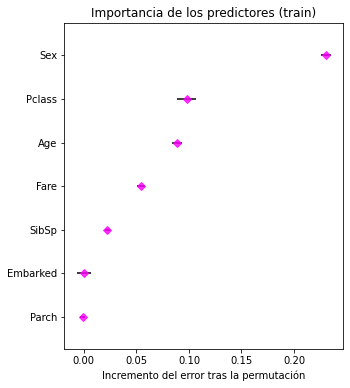

In [57]:
# Gráfico
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="magenta"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

### Conclusiones generales

Finalmente, y respondiendo a la pregunta base _"¿Qué tipo de personas tenían más probabilidades de sobrevivir?"_ podemos afirmar que en gran medida las predicciones de sobrevida estarán determinadas por el predictor `Sex`, como pudimos apreciar en un gráfico de barras inicial y validarlo por nuestros modelos, ser mujer representó un gran beneficio a la hora de sobrevivir a la tragedia, tal como se mecionó antes, un estudio interesante sería sobre las variables que influían en esto, dada la época que era, quizás termine siendo un estudio más cualitativo, pero podrían realizarse analisis de sentimientos sobre escritos, diarios publicaciones, o cartas de personas de la época, y generar modelos en vase a aquello, con la finalidad de respaldar el hecho de que el _"mujeres y niños primeros"_ respondía a valores o creencias de la época, y así mismo con otros factores.

Volviendo a lo relevante de nuestros hallazgos, podemos decir que en un segundo lugar estaba la clase a la cual se pertenecía (la clase del ticket o boleto de abordaje), ya que ocupa un segundo lugar como predictor, si nos guiamos por el estudio por permutación tanto en el caso de _"Random Forest"_  como en el de _"AdaBoost"_, además es congruente con lo indicado en nuestro gráfico de barras inicial, ser de primera clase daba una gran ventaja por sobre los de la tercera, de hecho sobrevivieron más personas, de las que murieron, en la primera clase.

`Age` es el tercer predictor que podría decir algo respecto a la supervivencia, aunque aporta en menor medida (hay que tener en cuenta que si la edad del pasajer era baja, igualmente la clase de su pasaje es la que diría mucho respecto a su supervivencia, más que la edad por sí sola...), en misma instancia se encuentra `Fare`, pero no hay que olvidar que dependiendo del número de permutaciones del modelo, se va haciendo cada vez menos relevante esta variable (eso sí, nos vendría bien revisar un boxplot de esta variable, ya que así podíamos ver que los que sobrevivieron tienen un promedio de precio más alto, lo que coindidiría con lo mencionado respecto a la clase). 

En el caso de los predictores menos influyentes quedaron `Pach` y `Embarked` por lo que, por ejemplo, haber embarcado en cierta ciudad, no nos daría mucha información sobre si la persona sobrevivió o no, o de si sobreviviría a un Titanic virtual, en nuestros modelos, por lo que no vale la pena ahondar mucho en esta información.

Respecto a los modelos como tal, los obtenidos por _"Random Forest"_ (del orden del 82,84% al 84,11% de accuracy aproximadamente) versus a lo obtenido por _"AdaBoost"_ (82.96% 84.30% de accuracy), no presenta mayores diferencias. 

Si comparamos extrictamente peras con peras y manzanas con manzanas, es decir las versiones con _"Grid Seach"_ y _"Cross Validation"_, es _"AdaBoost"_ (AB) quien presenta un mejor modelo por apenas un 0,12% de superaciómejoría versus su símil obtenido mediante _"Random Forest"_ (RF). Frente a esto el modelo de AB presenta menor índice de error en sus predicciones, respecto a sus predictores, por lo que es un modelo que entrega mayor seguridad respecto a lo que está devolviendo como información. Sólo por esto último es que finalmente me inclino a recomendar el modelo por AB.



📖
---

**Referencias**

- Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, Libro.

- Random Forest con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at [_(Link)_](https://www.cienciadedatos.net/documentos/py08_random_forest_python.html) 

- Random Forest using GridSearchCV, Akshay Nevrekar [_(Link)_](https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv/notebook)
- Scikit-learn.org/stable/modules/tree

- Scikit-learn.org/stable/modules/ensemble